#Importing the Necessary Library Modules:

In [68]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import LSTM,Dense ,Dropout, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, max_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf


In [70]:
data = pd.read_csv("CleanedFinalDateset/Lamachaurfinaldata.csv")
data.head()

,Date,Precipitation(mm)
0,2010-01-01,0.0
1,2010-01-02,0.0
2,2010-01-03,0.0
3,2010-01-04,0.0
4,2010-01-05,0.1


In [71]:
data.isnull().sum()

Date                 0
Precipitation(mm)    0
dtype: int64

In [72]:
data.describe()

,Precipitation(mm)
count,4854.000000
mean,10.442058
std,22.549666
min,0.000000
25%,0.000000
50%,0.000000
75%,8.600000
max,120.000000


In [73]:
train_dates=pd.to_datetime(data['Date'])

# Creating the lag features, so that model will capture the periodicity

In [74]:
#mentioned lag feature  for the min temperature
for i in [1,3]:
    data["lag_f{}".format(i)] = data['Precipitation(mm)'].shift(periods=i)

data['lag_f1']=data['lag_f1'].fillna(0)
data['lag_f3']=data['lag_f3'].fillna(0)
# data['lag_f5']=data['lag_f5'].fillna(0)

# data[['Precipitation(mm)', 'lag_f1', 'lag_f3', 'lag_f5' ]]

In [75]:
data[:10]

,Date,Precipitation(mm),lag_f1,lag_f3
0,2010-01-01,0.0,0.0,0.0
1,2010-01-02,0.0,0.0,0.0
2,2010-01-03,0.0,0.0,0.0
3,2010-01-04,0.0,0.0,0.0
4,2010-01-05,0.1,0.0,0.0
5,2010-01-06,0.0,0.1,0.0
6,2010-01-07,0.0,0.0,0.0
7,2010-01-08,0.0,0.0,0.1
8,2010-01-09,0.0,0.0,0.0
9,2010-01-10,0.0,0.0,0.0


In [76]:
data.to_csv('LamachaurPrecipitation.csv')

In [77]:
#drop the day of week and month column
# new_df = data.drop(['Date','day_of_week', 'month'], axis=1)
new_df = data.drop(['Date'], axis=1)


In [78]:
new_df.isnull().sum()

Precipitation(mm)    0
lag_f1               0
lag_f3               0
dtype: int64

In [79]:
#splitting training testing dataset
X_train, X_test, y_train, y_test = train_test_split(new_df, new_df['Precipitation(mm)'], test_size = 0.3, shuffle = False)
     

In [80]:
X_test[:5]

,Precipitation(mm),lag_f1,lag_f3
3397,0.0,0.0,2.0
3398,0.0,0.0,0.0
3399,6.0,0.0,0.0
3400,0.0,6.0,0.0
3401,0.0,0.0,0.0


#To normalize the data into the same differences

In [81]:
#Normalize the data and  change into array and reshape to fit the LSTM model
scaler = StandardScaler()

#normalize the train and test dataset
X_train_arr=scaler.fit_transform(X_train)
X_test_arr=scaler.transform(X_test)

#reshaping it into the single column data 
y_train_arr=scaler.fit_transform(np.array(y_train).reshape(-1,1))
y_test_arr=scaler.transform(np.array(y_test).reshape(-1,1))

trainX = X_train_arr.reshape((X_train_arr.shape[0], 1 ,X_train_arr.shape[1]))
trainY = y_train_arr.reshape((y_train_arr.shape[0], 1, y_train_arr.shape[1]))

testX= X_test_arr.reshape((X_test_arr.shape[0], 1 ,X_test_arr.shape[1]))
testY = y_test_arr.reshape((y_test_arr.shape[0], 1, y_test_arr.shape[1]))

In [82]:
trainX[:2]

array([[[-0.45488895, -0.45488895, -0.45485687]],

       [[-0.45488895, -0.45488895, -0.45485687]]])

# Building Model

In [83]:
#Building the model
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(128, input_shape=((1,3)), activation='relu', return_sequences=True),
  tf.keras.layers.LSTM(32, activation='relu'),
  tf.keras.layers.Dense(1)
  ])




In [84]:
  # Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.8)


  # Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 128)            67584     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 88,225
Trainable params: 88,225
Non-trainable params: 0
_________________________________________________________________


In [85]:
model_history = model.fit(trainX, trainY, batch_size= 32, validation_data=(testX,testY), epochs=10)

Epoch 1/10
107/107 [==============================] - 3s 9ms/step - loss: 0.2847 - val_loss: 0.3445
Epoch 2/10
107/107 [==============================] - 1s 7ms/step - loss: 0.2792 - val_loss: 0.3404
Epoch 3/10
107/107 [==============================] - 1s 10ms/step - loss: 0.2754 - val_loss: 0.3352
Epoch 4/10
107/107 [==============================] - 1s 10ms/step - loss: 0.2697 - val_loss: 0.3270
Epoch 5/10
107/107 [==============================] - 1s 9ms/step - loss: 0.2611 - val_loss: 0.3127
Epoch 6/10
107/107 [==============================] - 1s 7ms/step - loss: 0.2458 - val_loss: 0.2880
Epoch 7/10
107/107 [==============================] - 2s 15ms/step - loss: 0.2148 - val_loss: 0.2262
Epoch 8/10
107/107 [==============================] - 1s 7ms/step - loss: 0.1219 - val_loss: 0.0554
Epoch 9/10
107/107 [==============================] - 1s 8ms/step - loss: 0.0349 - val_loss: 0.0298
Epoch 10/10
107/107 [==============================] - 1s 7ms/step - loss: 0.0202 - val_loss: 0.0

# Loss in Training and Validation over the different epoches


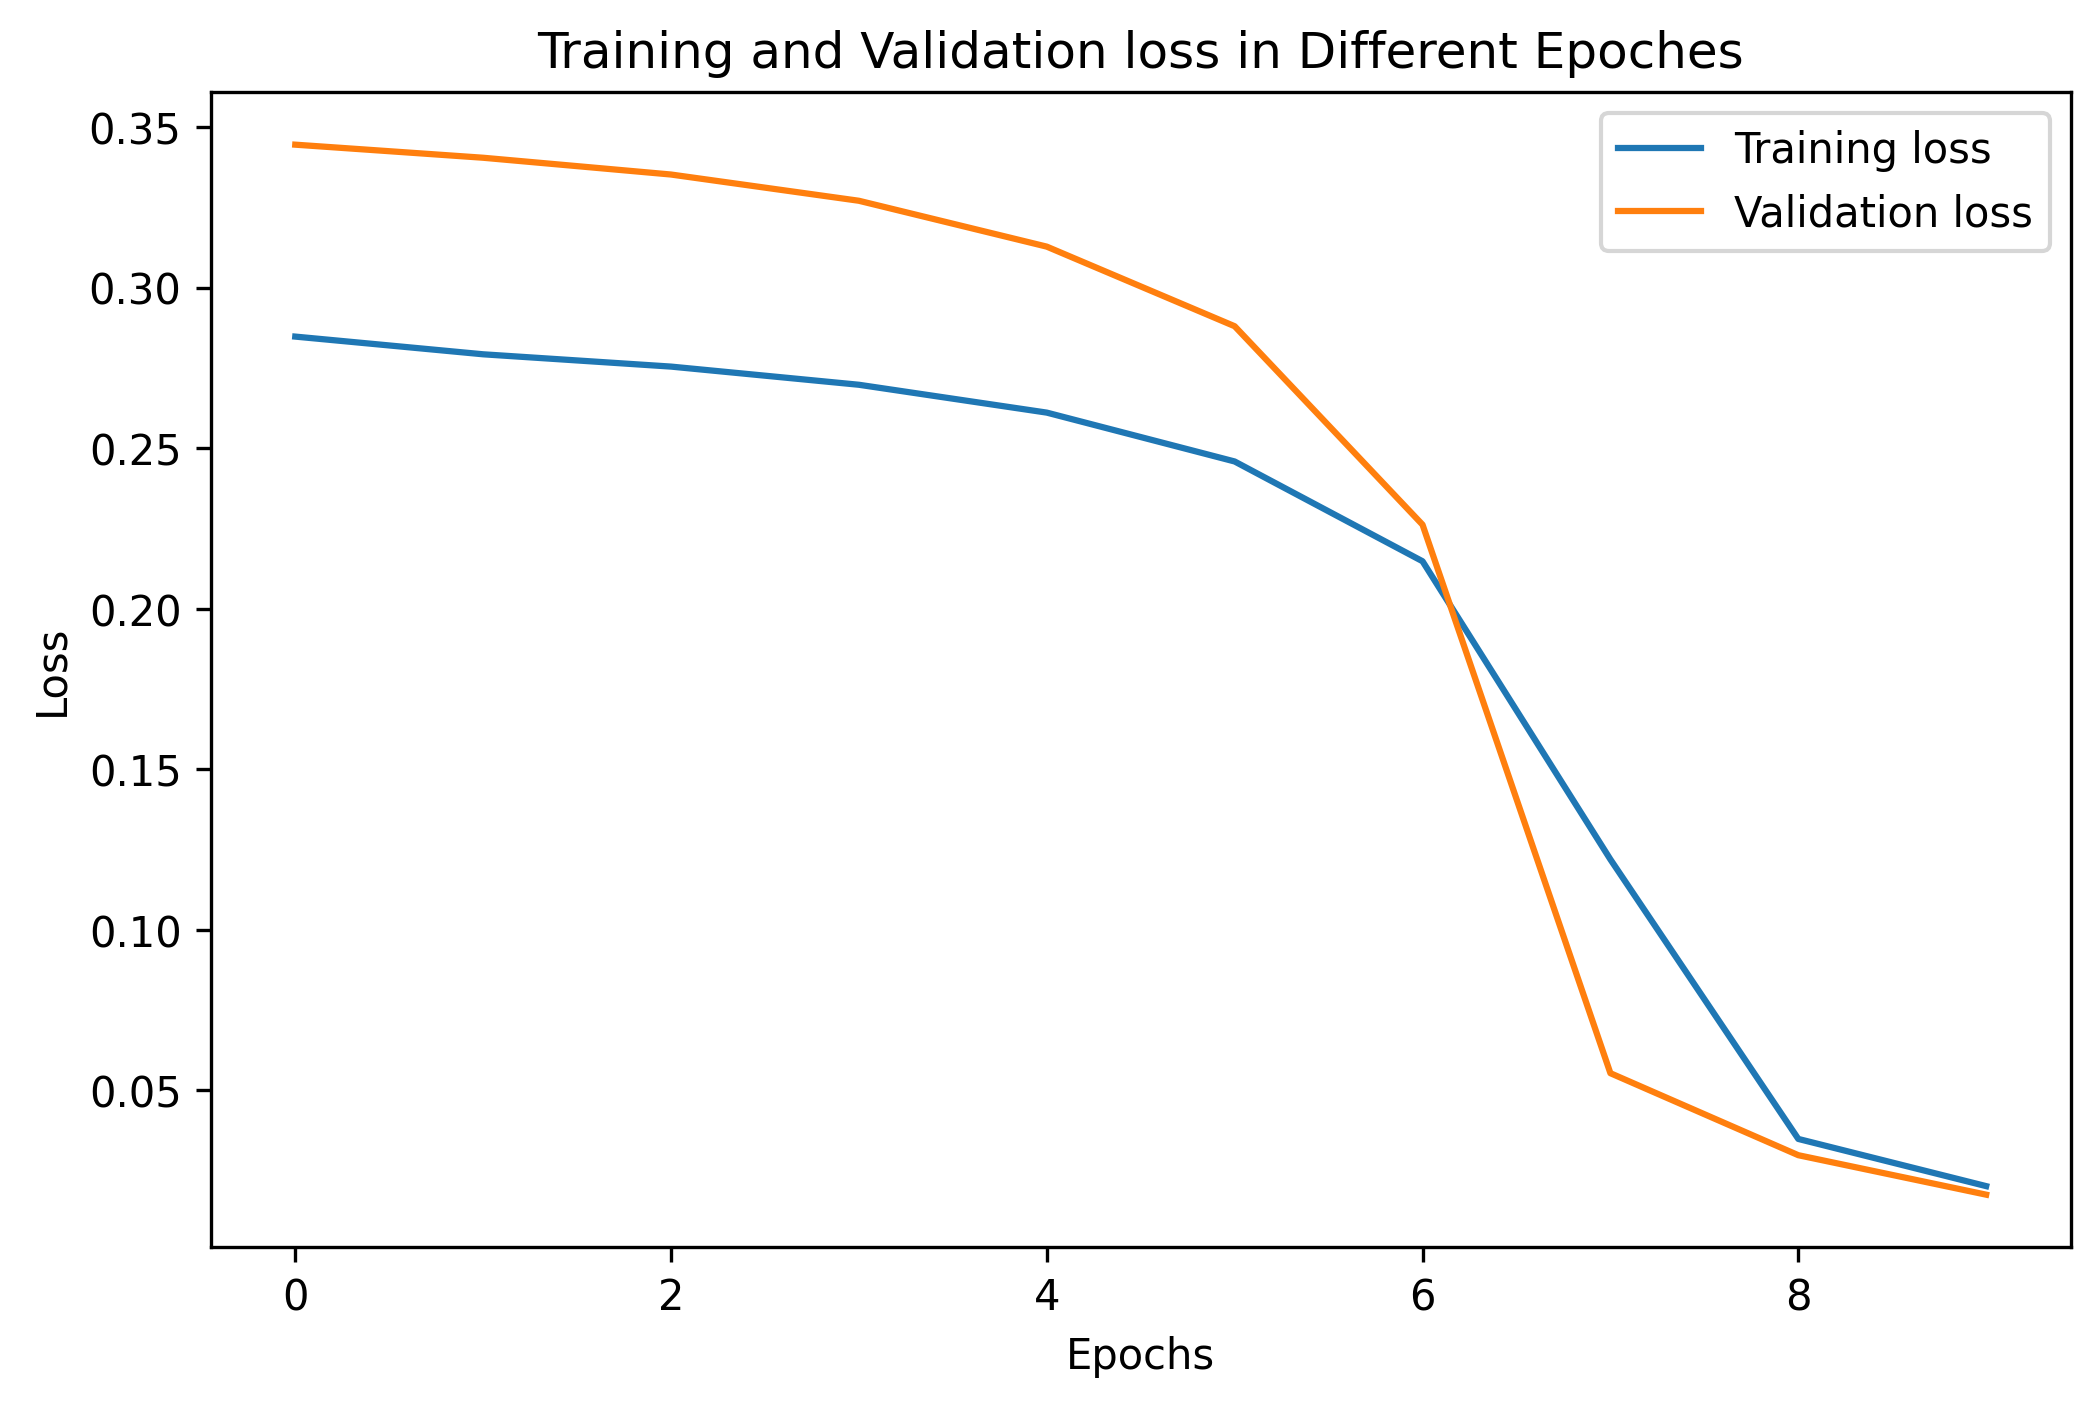

In [86]:
#to plot the loss over the training and validation epoch we can do now as 
history_df = pd.DataFrame(model_history.history)
plt.figure(figsize=(8,5), dpi=300)
plt.plot(history_df.loc[:, ['loss']], label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']], label='Validation loss')
plt.title('Training and Validation loss in Different Epoches')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

# Plotting the Predicted and Actual Graphs and Evaluations

Text(0.5, 1.0, 'Lamachaur Precipitation Actual Data Vs Predicted Data in Train Dataset')

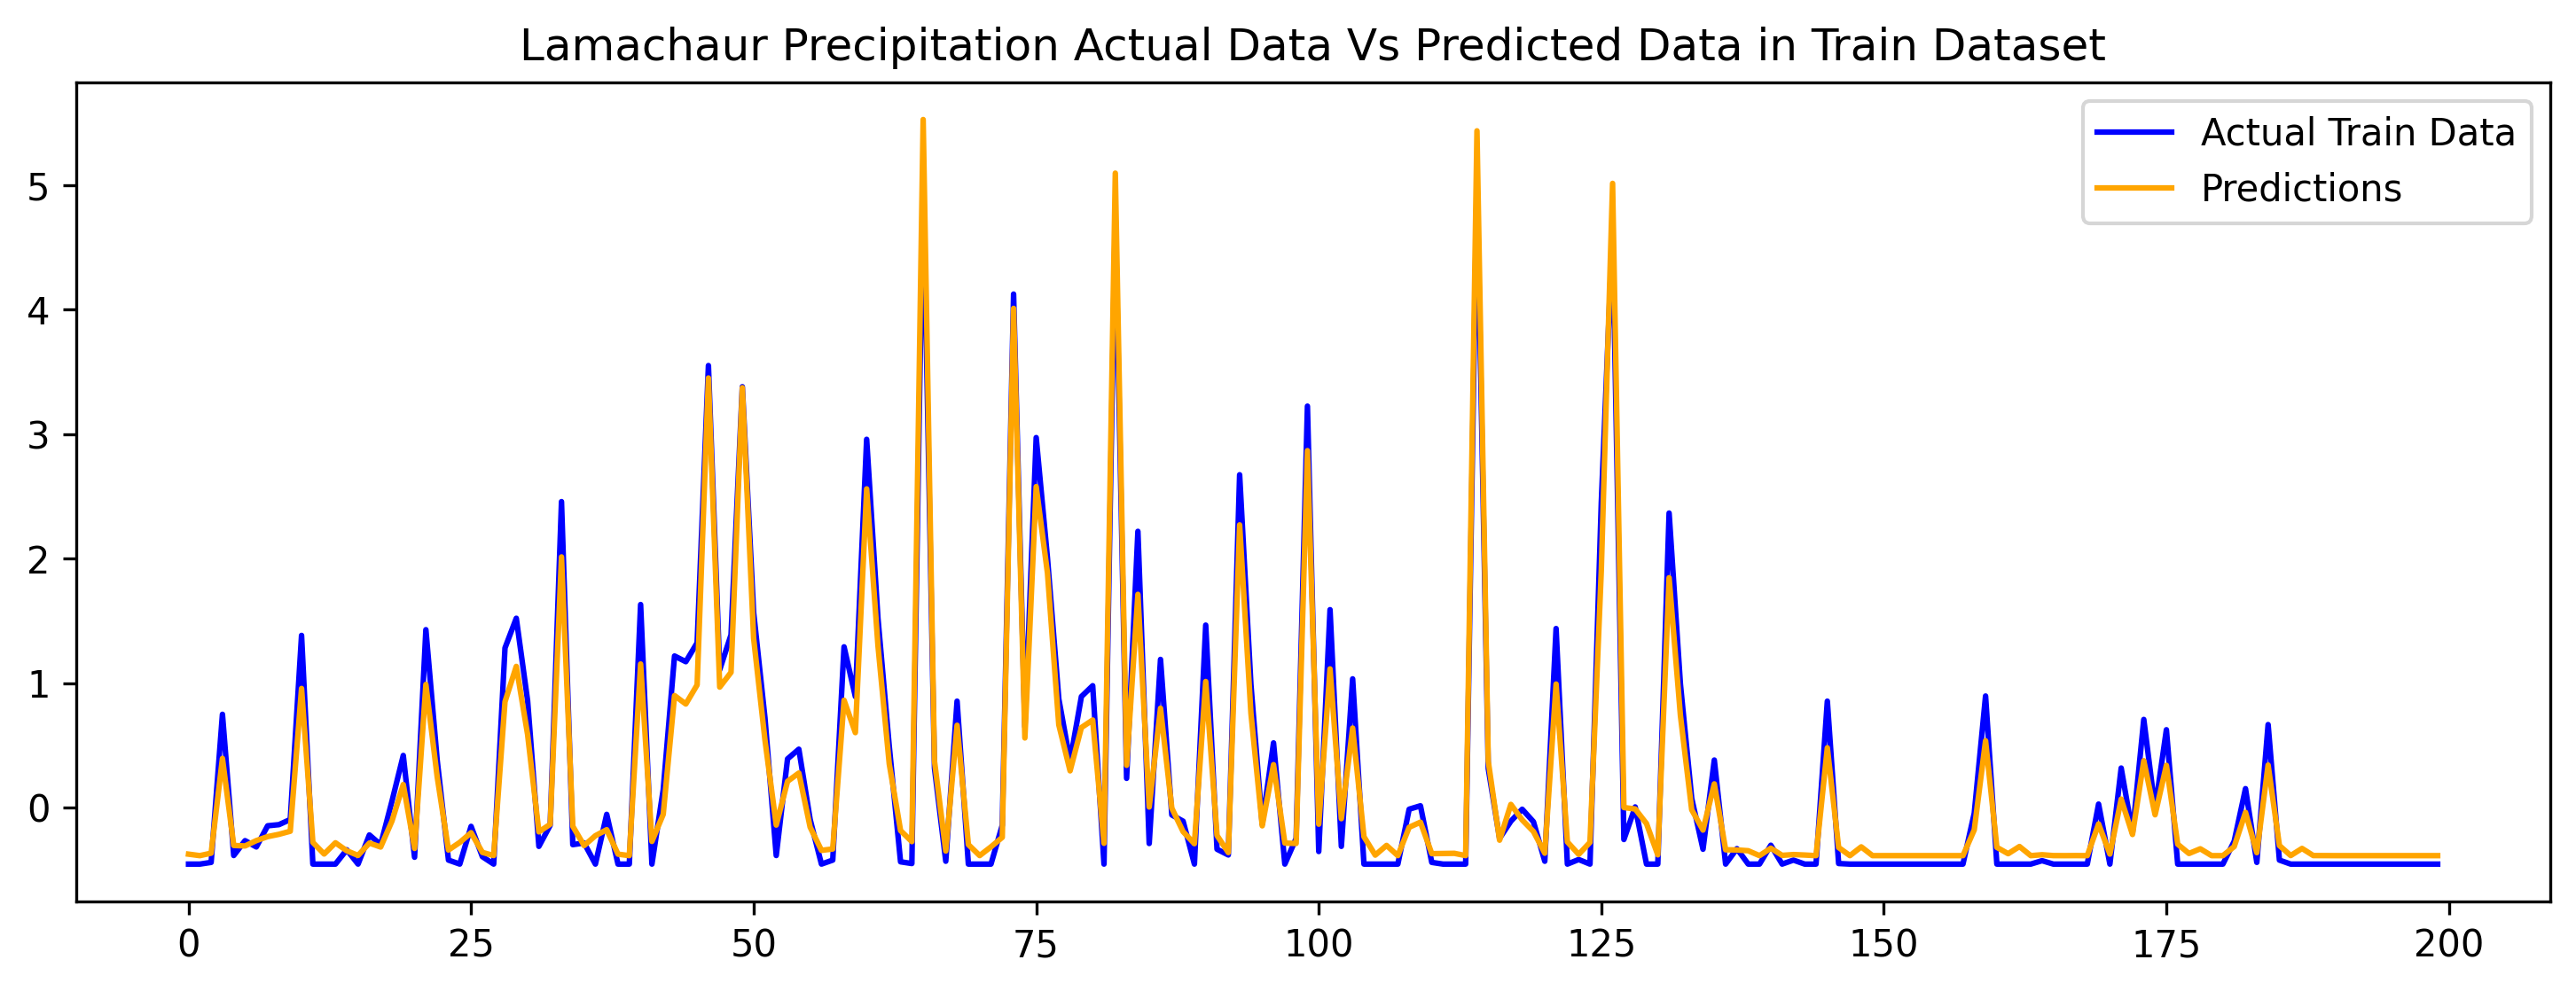

In [87]:
#Plotting the Predicted  vs Real Data  of Triaining Data| Training Accuracy
yPredict_train =model.predict(trainX, verbose=0)

fig,ax = plt.subplots(figsize=(12,4), dpi=300)

ax.plot(y_train_arr[500:700], color='blue', linewidth=1.5, label = "Actual Train Data")
ax.plot(yPredict_train[500:700], color='orange',linewidth=1.5,label = "Predictions")

ax.legend()
ax.set_title('Lamachaur Precipitation Actual Data Vs Predicted Data in Train Dataset')

Text(0.5, 1.0, 'Lamachaur Precipitation Actual Data Vs Predicted Data in Test set')

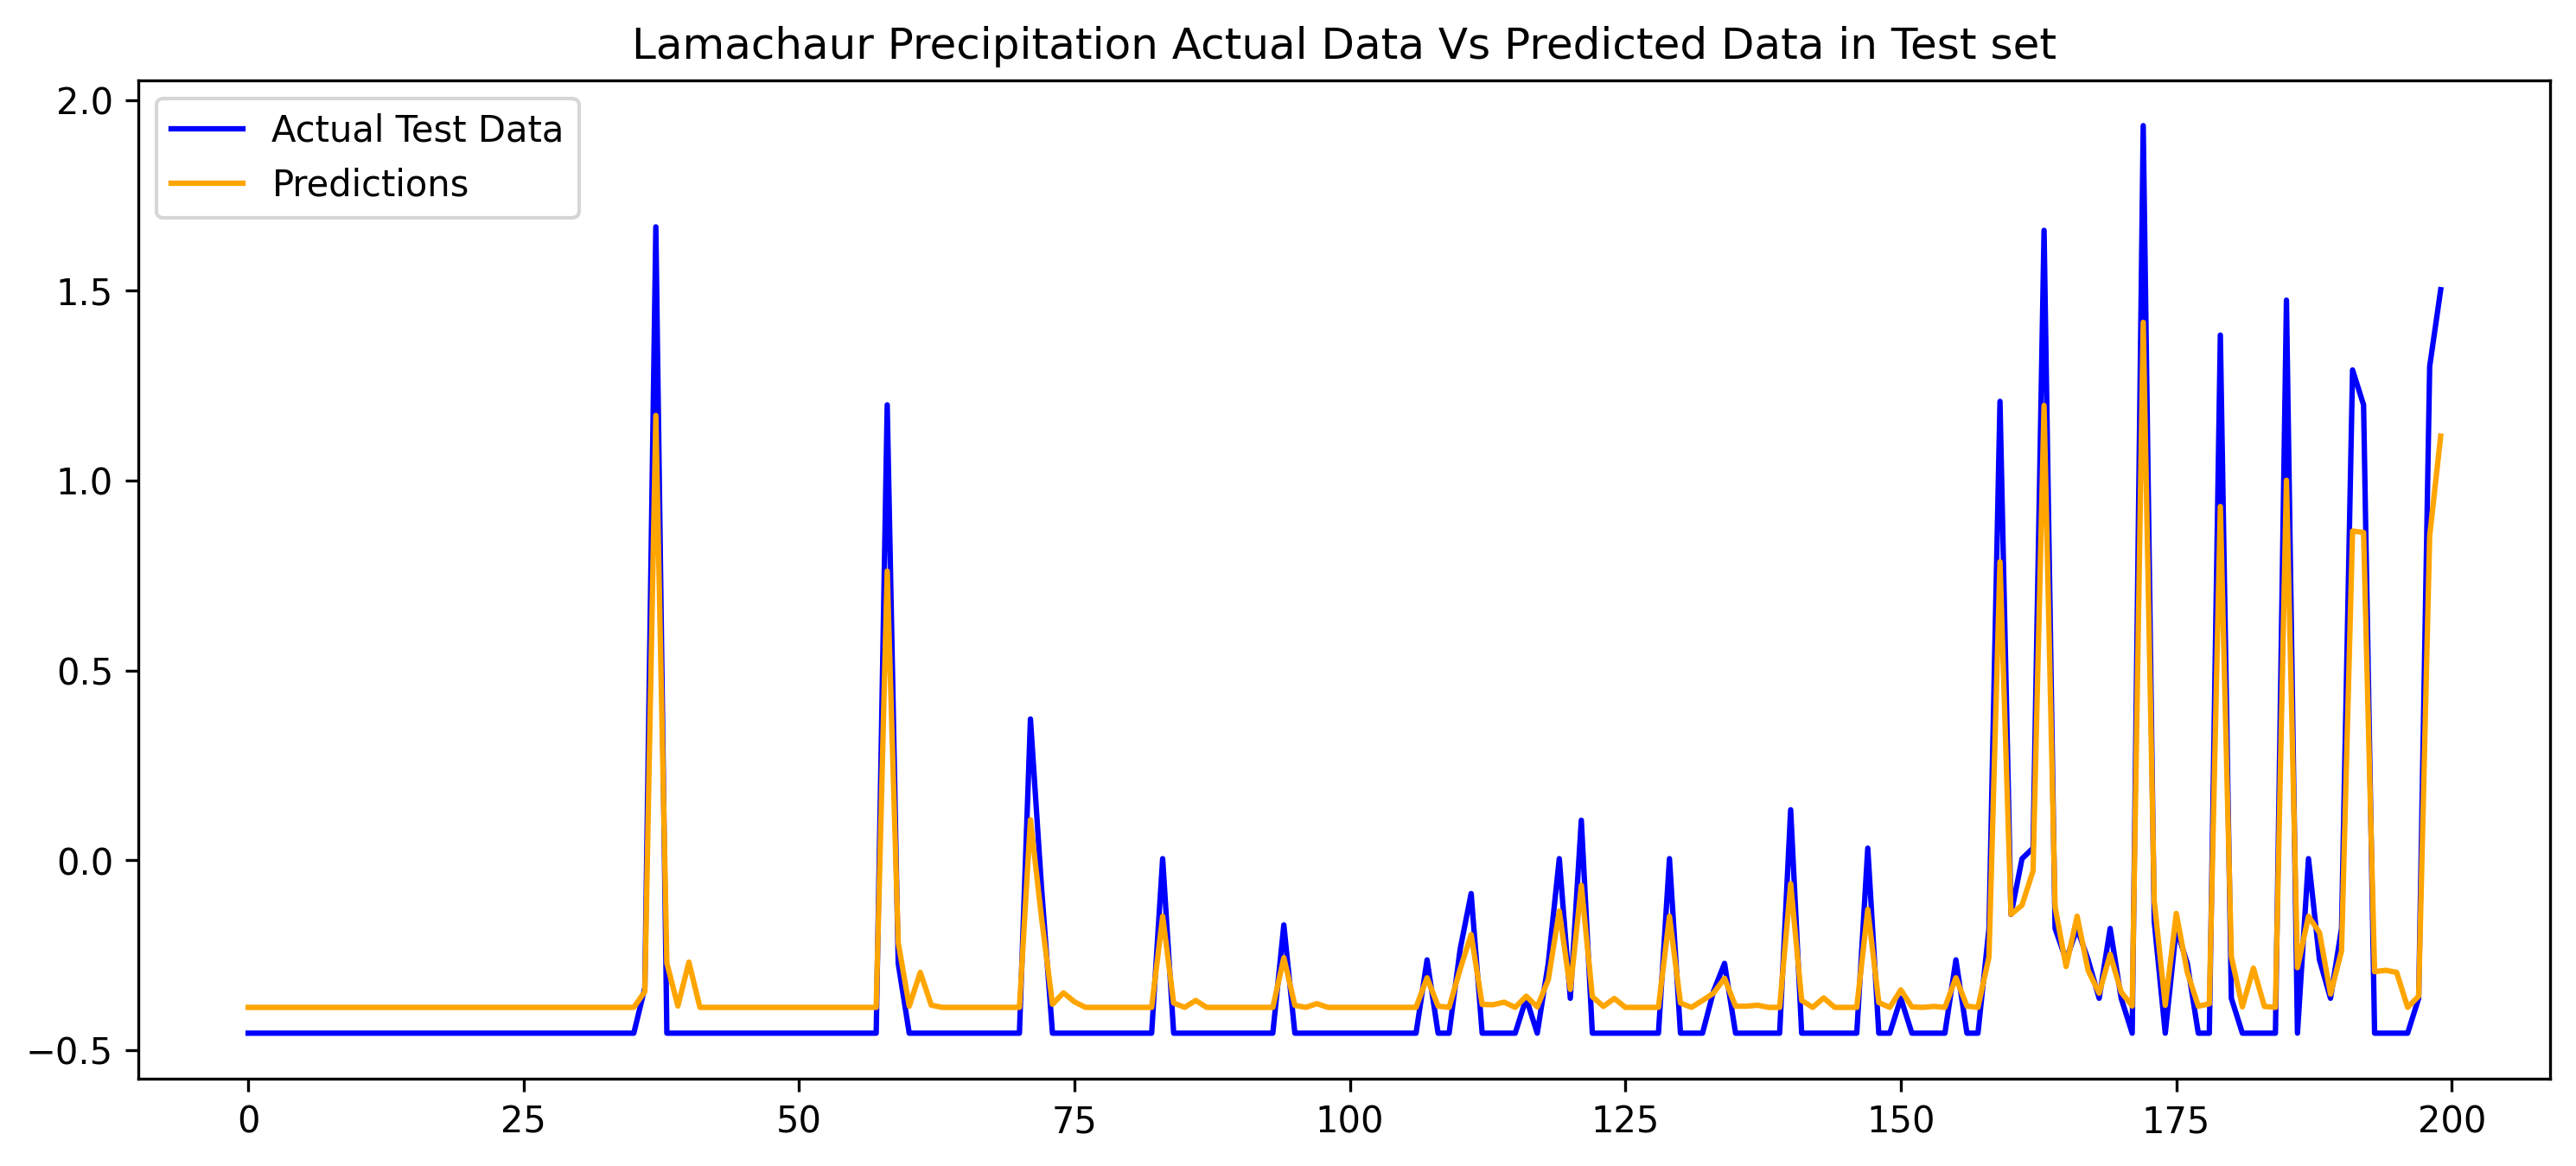

In [88]:
#Plotting the Predicted vs Testing accuracy aspect
yPredict_train =model.predict(testX, verbose=0)


import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(12,5), dpi=300)

ax.plot(y_test_arr[200:400], color='blue', linewidth=1.5, label = "Actual Test Data")
ax.plot(yPredict_train[200:400], color='orange',linewidth=1.5,label = "Predictions")

ax.legend()
ax.set_title('Lamachaur Precipitation Actual Data Vs Predicted Data in Test set')

#Calculating RMSE and Accuracy of Model

In [89]:
def Evaluation(train, train_pred, test, test_pred):
  # calculate root mean squared error
  train_rmse = np.sqrt(mean_squared_error(train, train_pred))
  print('Train RMSE: %.2f' % (train_rmse))
  test_rmse = np.sqrt(mean_squared_error(test, test_pred))
  print('Test RMSE: %.2f' % (test_rmse))

  # calculate root mean absolute error
  train_mae = mean_absolute_error(train, train_pred)
  print('Train MAE: %.2f' % (train_mae))
  test_mae = mean_absolute_error(test, test_pred)
  print('Test MAE: %.2f' % (test_mae))

  # Calculate r2_score
  train_r2 = r2_score(train, train_pred)
  print('Train r2 score: %.2f' % (train_r2))
  test_r2 = r2_score(test, test_pred)
  print('Test r2 score: %.2f' % (test_r2))

In [90]:
yPredict_train = model.predict(trainX, verbose=0)
yPredict_test = model.predict(testX, verbose=0)

Denormalize_yPredict_train = scaler.inverse_transform(yPredict_train)
Denormalize_trainY = scaler.inverse_transform(y_train_arr)
Denormalize_yPredict_test = scaler.inverse_transform(yPredict_test)
Denormalize_testY = scaler.inverse_transform(y_test_arr)

In [91]:
Evaluation(Denormalize_trainY, Denormalize_yPredict_train, Denormalize_testY, Denormalize_yPredict_test)

Train RMSE: 3.78
Test RMSE: 4.08
Train MAE: 2.73
Test MAE: 2.87
Train r2 score: 0.97
Test r2 score: 0.97


In [92]:
Denormalize_testY.shape

(1457, 1)

In [93]:
#make it into one column data so that concat will be easy
Predicted=Denormalize_yPredict_test.reshape(-1)
Actual=Denormalize_testY.reshape(-1)

In [94]:
#Concatination the result 
test_results=pd.DataFrame(data={'Predicted Precipitation(mm)':Predicted, 'Actuals Precipitation(mm)': Actual})
test_results

,Predicted Precipitation(mm),Actuals Precipitation(mm)
0,1.534447,0.0
1,1.479114,0.0
2,4.203650,6.0
3,1.590544,0.0
4,1.479114,0.0
...,...,...
1452,1.479114,0.0
1453,1.479114,0.0
1454,1.479114,0.0
1455,1.479114,0.0


 # Tomorrow Prediction

In [95]:
next_day_predict=model.predict(testX[-1:])
next_day=scaler.inverse_transform(next_day_predict)
next_day

1/1 [==============================] - 0s 22ms/step


array([[1.4791133]], dtype=float32)

# Model Saving

In [97]:
# save the model to a file in .h5 format
model.save('model/LamachaurPrecipitation.h5')